# Importing Packages & Loading Data

In [52]:
message = "wed morning updates"
jovian.commit(message=message, git_message=message)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "sejaldua/playground" on https://jovian.ai
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/sejaldua/playground


'https://jovian.ai/sejaldua/playground'

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings 
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv('workout_data.csv', parse_dates=['timestamp'])
df.head()

,timestamp,fitness_discipline,title,duration,instructor,calories,distance,avg_hr
0,2021-08-02 18:03:24+00:00,running,30 min J Balvin Run,1800,Robin Arzón,315,3.28,169
1,2021-08-01 15:44:11+00:00,running,45 min Endurance Run,2700,Becs Gentry,420,4.92,172
2,2021-07-30 17:12:49+00:00,running,30 min Tropical House Run,1800,Selena Samuela,334,3.28,173
3,2021-07-29 13:21:49+00:00,running,30 min Intervals Run,1800,Becs Gentry,346,3.39,174
4,2021-07-22 18:59:52+00:00,running,20 min Intervals Run,1200,Chase Tucker,61,0.66,150


# Data Cleaning & Wrangling

In [29]:
# convert duration from seconds to minutes
df['duration'] = df['duration'].apply(lambda x: x // 60)

In [30]:
# creating new datetime-based features
df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(x).tz_convert('US/Eastern'))
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.day_name()
df['week_num'] = df['timestamp'].apply(lambda x: x.isocalendar()[1])

In [31]:
# get weekday_num in order of MTWTFSS because we want to sort the rows of the heatmap in order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {k: v for k, v in zip(weekday_order, [i+1 for i in range(7)])}
df['weekday_num'] = df['weekday'].apply(lambda x: mapping[x])

In [32]:
# let's also save a variable of month abbreviations for tick labeling purposes later
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

In [33]:
# filter out 'Just Run' because only interested in Peloton on-demand classes
df = df[~df.title.str.contains('Just Run')]

# strip the first part of the titles, which indicates the duration (e.g. '45 min ...')
run_titles = list(df['title'])
run_titles = [x[7:] if int(x[:2]) else x for x in run_titles]

# inspect the unique types of runs in the dataset
print(set(run_titles))

{'Long Run Warm Up', 'Tropical House Run', 'Pop Run', 'Breakthrough Run', 'Pop Punk Run', 'Hip Hop Run', 'Intervals Run', 'Tempo Run', 'HIIT & Hills Run', 'EDM Run', 'Beyoncé Run', 'J Balvin Run', 'HIIT Run', 'Rock Run', 'Endurance Run', 'House Run', 'Progression Run'}


In [34]:
# devise a mapping strategy to partition runs into categories
def get_run_type(x):
    types = ['Endurance', 'Intervals', 'HIIT & Hills', 'HIIT', 'Warm Up', 'Cool Down', 'Tempo', 'Progression']
    for run_type in types:
        if run_type in x:
            return run_type
        
    # there are many runs based on musical genre (Beyonce, J Balvin, Hip Hop, EDM, ...)
    # designate these runs as 'Music' runs
    # serves as a catch-all if no specific training category applies
    return "Music"

df['run_type'] = df['title'].apply(lambda x: get_run_type(x))

In [35]:
# filter dataset to only look at running workouts in 2021
data_2021 = df[(df['year'] == 2021) & (df['fitness_discipline'] == 'running')]
data_2021

,timestamp,fitness_discipline,title,duration,instructor,calories,distance,avg_hr,year,month,hour,weekday,week_num,weekday_num,run_type
0,2021-08-02 14:03:24-04:00,running,30 min J Balvin Run,30,Robin Arzón,315,3.28,169,2021,8,14,Monday,31,1,Music
1,2021-08-01 11:44:11-04:00,running,45 min Endurance Run,45,Becs Gentry,420,4.92,172,2021,8,11,Sunday,30,7,Endurance
2,2021-07-30 13:12:49-04:00,running,30 min Tropical House Run,30,Selena Samuela,334,3.28,173,2021,7,13,Friday,30,5,Music
3,2021-07-29 09:21:49-04:00,running,30 min Intervals Run,30,Becs Gentry,346,3.39,174,2021,7,9,Thursday,30,4,Intervals
4,2021-07-22 14:59:52-04:00,running,20 min Intervals Run,20,Chase Tucker,61,0.66,150,2021,7,14,Thursday,29,4,Intervals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2021-02-12 14:24:54-05:00,running,20 min Beyoncé Run,20,Robin Arzón,183,2.05,67,2021,2,14,Friday,6,5,Music
78,2021-02-06 11:20:28-05:00,running,30 min Pop Run,30,Jess Sims,565,3.22,168,2021,2,11,Saturday,5,6,Music
79,2021-02-03 12:25:54-05:00,running,20 min Intervals Run,20,Olivia Amato,165,1.33,130,2021,2,12,Wednesday,5,3,Intervals
80,2021-02-03 11:59:34-05:00,running,20 min HIIT Run,20,Adrian Williams,185,1.67,150,2021,2,11,Wednesday,5,3,HIIT


# Seaborn Visualizations

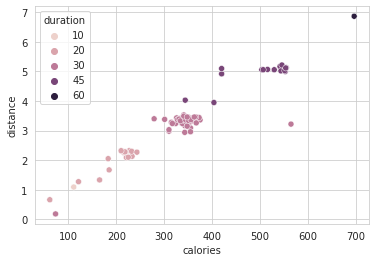

In [36]:
sns.scatterplot(data=data_2021, x='calories', y='distance', hue='duration');

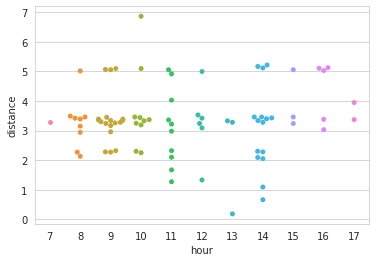

In [37]:
sns.swarmplot(data=data_2021, x='hour', y='distance');

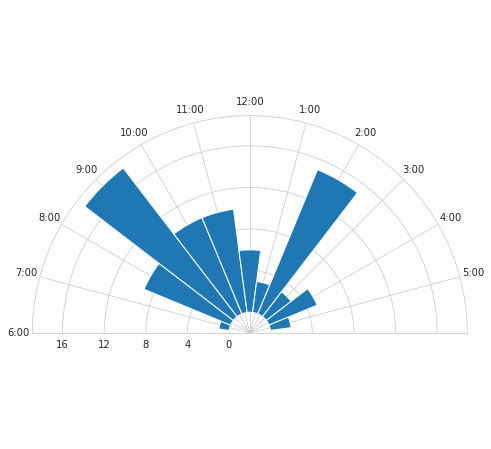

In [38]:
sns.set_style('whitegrid')
arr = list(df['hour'])
N = 12
bottom = 2

# create theta for 12 hours
theta = np.linspace(0.0, np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
_, tick = np.histogram(arr, bins = N)
radii = df['hour'].value_counts().sort_index().reindex([i+1 for i in range(5, 5+N)]).fillna(0)

# width of each bin on the plot
width = (np.pi) / N

# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the left-hand side (West)
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1) # clockwise

# we just want half of the polar chart
ax.set_thetamin(0)
ax.set_thetamax(180)


# setting xticks and xticklabels
ax.set_xticks(np.pi/180 * np.linspace(0, 180, N, endpoint=False))
ticks = [str(x % 12) + ":00" if x != 12 else "12:00" for x in radii.index]
ax.set_xticklabels(ticks);
ax.set_rgrids([4*i + 2 for i in range(5)], labels=[str(x-2) for x in [4*i + 2 for i in range(5)]])

plt.show()

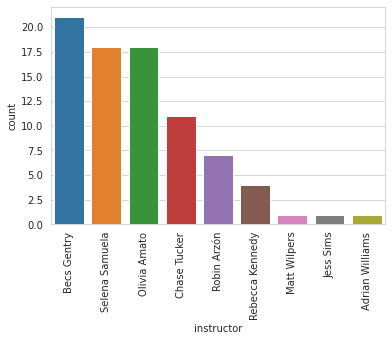

In [39]:
ax = sns.countplot(data=data_2021, x='instructor', 
                   order=data_2021['instructor'].value_counts().index);
plt.xticks(rotation=90);
plt.show()

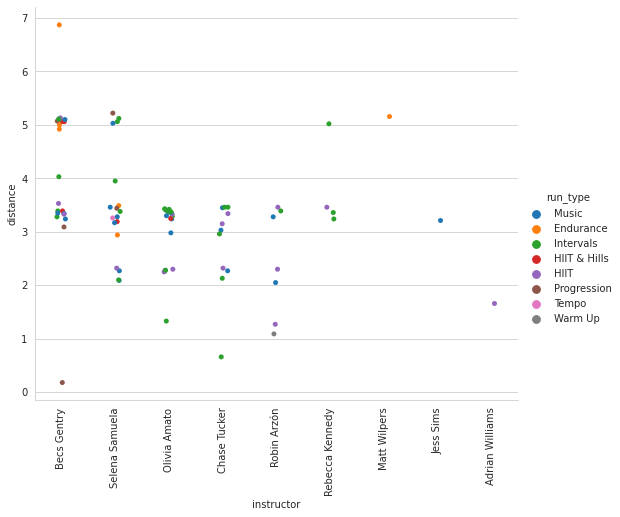

In [40]:
ax = sns.catplot(data=data_2021, x='instructor', y='distance', hue='run_type', 
                   order=data_2021['instructor'].value_counts().index, height=6, aspect=1.2);
plt.xticks(rotation=90);
plt.show()

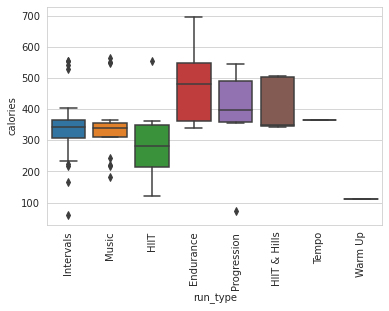

In [41]:
ax = sns.boxplot(data=data_2021, x='run_type', y='calories',
                   order=data_2021['run_type'].value_counts().index);
plt.xticks(rotation=90);
plt.show()

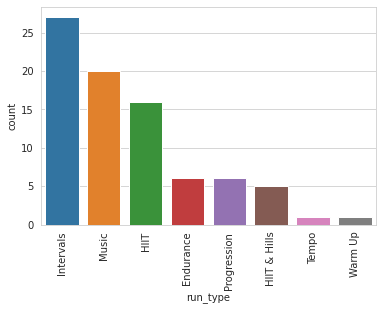

In [42]:
ax = sns.countplot(data=data_2021, x='run_type', 
                   order=data_2021['run_type'].value_counts().index);
plt.xticks(rotation=90);
plt.show()

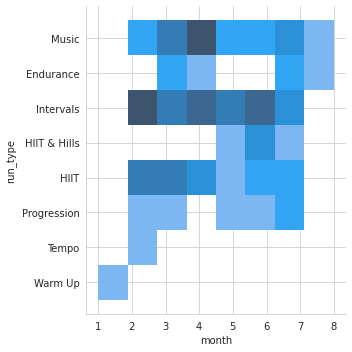

In [43]:
sns.displot(data=data_2021, x='month', y='run_type');

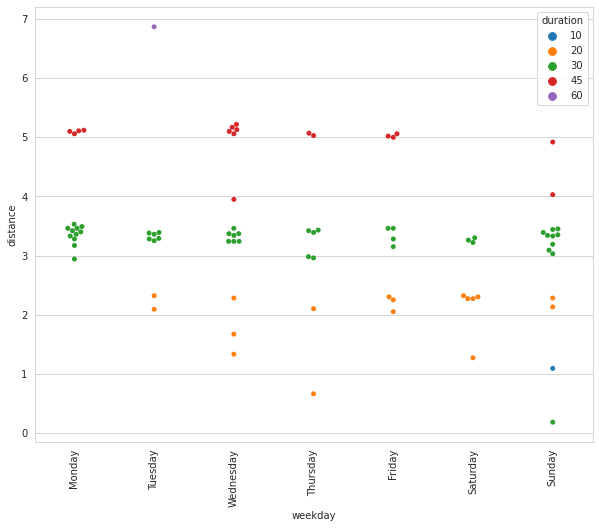

In [44]:
fig = plt.figure(figsize=(10,8));
ax = sns.swarmplot(data=data_2021, x='weekday', y='distance', order=weekday_order, 
                   hue='duration');
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax;

<AxesSubplot:xlabel='timestamp'>

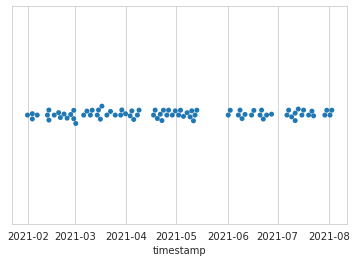

In [45]:
sns.swarmplot(x=data_2021['timestamp'])

In [46]:
df_to_pivot = data_2021[['week_num', 'weekday_num', 'distance']]
pivoted_data = pd.pivot_table(df_to_pivot, values='distance', index=['weekday_num'], columns=['week_num'], aggfunc=np.mean)
pivoted_data = pivoted_data.reindex([i+1 for i in range(max(pivoted_data.columns))], axis=1)
pivoted_data

week_num,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
weekday_num,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,3.46,2.94,...,NaN,3.17,NaN,3.42,NaN,NaN,NaN,5.06,NaN,3.28
2,NaN,NaN,NaN,NaN,NaN,NaN,3.38,NaN,NaN,NaN,...,3.29,3.28,3.39,2.32,NaN,2.090,6.87,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.50,NaN,NaN,3.46,NaN,3.37,...,3.24,2.28,3.37,NaN,NaN,3.240,NaN,5.17,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.42,...,NaN,NaN,NaN,5.07,NaN,NaN,3.43,0.66,3.39,NaN
5,NaN,NaN,NaN,NaN,NaN,2.050,3.15,3.46,NaN,NaN,...,NaN,5.06,NaN,NaN,NaN,2.250,2.30,NaN,3.28,NaN
6,NaN,NaN,NaN,NaN,3.22,1.795,3.26,NaN,2.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.09,NaN,NaN,NaN,2.86,NaN,3.34,...,NaN,NaN,3.19,2.13,NaN,1.635,NaN,NaN,4.92,NaN


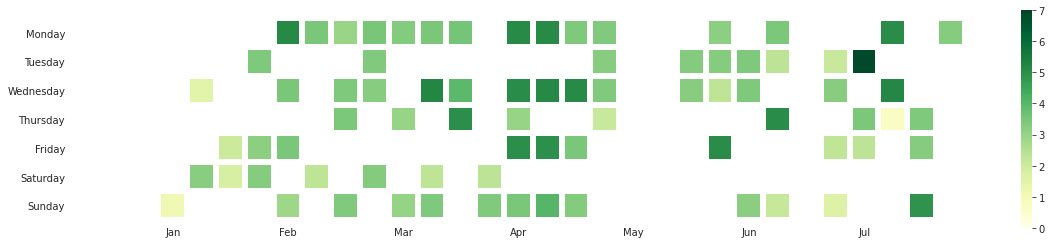

In [47]:
plt.figure(figsize=(20,4));
space = [" ", " ", " "]
sns.heatmap(pivoted_data, linewidths=6, vmin=0, vmax=7, cmap='YlGn', cbar=True,
                 linecolor='white', square=True, yticklabels=weekday_order, 
            xticklabels=[*space, 'Jan', *space, 'Feb', *space, 'Mar', *space, 'Apr', 
                         *space, 'May', *space, 'Jun', *space, 'Jul']);
plt.ylabel("");
plt.xlabel("");

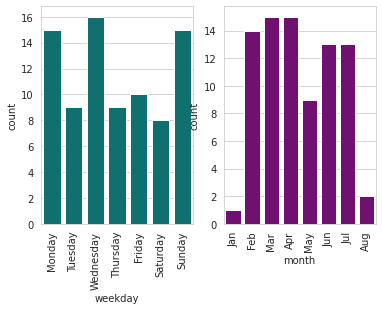

In [48]:
fig, ax = plt.subplots(1,2);
sns.countplot(data=data_2021, x='weekday', order=weekday_order, color='teal', ax=ax[0]);
sns.countplot(data=data_2021, x='month', color='purple',
                   order=[i+1 for i in range(max(data_2021['month']))], ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90);
ax[1].set_xticklabels(month_order, rotation=90);
plt.show()

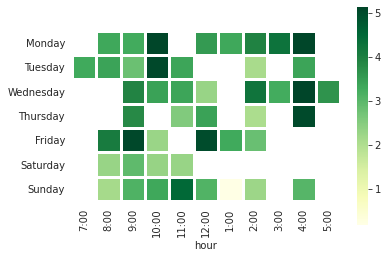

In [50]:
df_pivoted = pd.pivot_table(data_2021[['weekday_num', 'hour', 'distance']], 
                           values='distance', index=['weekday_num'], 
                           columns=['hour'], aggfunc=np.mean)
sns.heatmap(df_pivoted, cmap='YlGn', yticklabels=weekday_order, square=True, linewidths=3,
            xticklabels = [str(x % 12) + ":00" if x != 12 else "12:00" for x in df_pivoted.columns]);
plt.ylabel("");


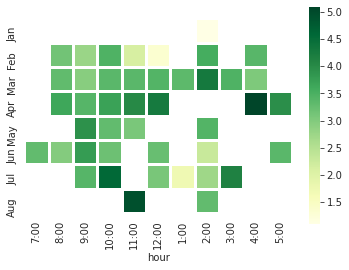

In [51]:
df_pivoted = pd.pivot_table(data_2021[['month', 'hour', 'distance']], 
                           values='distance', index=['month'], 
                           columns=['hour'], aggfunc=np.mean)
sns.heatmap(df_pivoted, cmap='YlGn', square=True, linewidths=3,
            yticklabels=month_order, 
            xticklabels = [str(x % 12) + ":00" if x != 12 else "12:00" for x in df_pivoted.columns]);
plt.ylabel("");